# Определение количества лицензий ЛОЦМАН:КБ 

Компаниям, разрабатывающим и использующим конструкторскую документацию, требуется специализированная среда, в которой бы можно было реализовать управление жизненным циклом документации — от разработки до аннулирования. Системы, которые обеспечивают инженерный документооборот, относятся к классу PDM (Product Data Management – Управление инженерными данными).  

*ЛОЦМАН:КБ позволяет:*
- организовать файловый архив и архив электронных структур изделия;  
- обеспечить среду для коллективной (в т.ч. удалённой) разработки;  
- автоматизировать процедуры согласования документации;  
- корректно проводить изменения, поддерживая тем самым актуальность архива.
    
*При этом ЛОЦМАН:КБ продается только с сетевой лицензией.*  

Cетевая лицензия — даёт право установить продукт на несколько компьютеров, но при этом количество одновременных пользователей не должно превышать количества купленных лицензий.   

*Общий алгоритм работы сетевой версии:*
- На одном компьютере разворачивается специальная программа-менеджер лицензий — это сервер.
- На рабочих местах устанавливается само приложение. Количество таких установок неограниченно.
- В момент запуска приложения на рабочем месте, оно обращается на сервер и берет лицензию (если на сервере есть свободные лицензии).
- В момент окончания работы приложения или по таймауту лицензия возвращается на сервер.


Таким образом, количество одновременно работающих в сети рабочих мест ограничено количеством приобретенных сетевых лицензий.    

  
  

**Цель исселедования:**   
Определить оптимальное число требуемых сетевых лицензий ЛОЦМАН:КБ.

## Шаг 1. Изучение общей информации о данных и предобработка данных для анализа

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
from math import factorial

In [2]:
pd.options.display.max_colwidth = 100

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Оценим *.log файл за 1 октября 2021 года:

In [4]:
df = pd.read_csv(f"/content/drive/My Drive/projects/determining_number_licenses_lodsman/logs/2021_10_01_access.log",
                    sep=r' ', skiprows=1, error_bad_lines=False, warn_bad_lines=False)
df.head()

,Unnamed: 0,n/a},0}2021-10-01,00:00:05,192.168.0.102:58419,[SRM]@192.168.0.102,POST:1947,/api/features,FEATURES(span=0),result(0),Unnamed: 10
0,NaN,n/a},0}2021-10-01,00:00:15,192.168.0.101:55291,[SRM]@192.168.0.101,POST:1947,/api/features,FEATURES(span=4),result(0),NaN
1,NaN,n/a},0}2021-10-01,00:00:16,192.168.0.135:64676,[SRM]@192.168.0.135,POST:1947,/api/features,FEATURES(span=0),result(0),NaN
2,NaN,n/a},0}2021-10-01,00:00:18,192.168.0.199:56061,[SRM]@192.168.0.199,POST:1947,/api/features,FEATURES(span=0),result(0),NaN
3,NaN,n/a},0}2021-10-01,00:00:23,192.168.0.142:60687,[SRM]@192.168.0.142,POST:1947,/api/features,FEATURES(span=0),result(0),NaN
4,NaN,n/a},0}2021-10-01,00:00:29,192.168.0.155:7634,[SRM]@192.168.0.155,POST:1947,/api/features,FEATURES(span=4),result(0),NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34282 entries, 0 to 34281
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           8 non-null      object
 1   n/a}                 34282 non-null  object
 2   0}2021-10-01         34282 non-null  object
 3   00:00:05             34281 non-null  object
 4   192.168.0.102:58419  34281 non-null  object
 5   [SRM]@192.168.0.102  34281 non-null  object
 6   POST:1947            34281 non-null  object
 7   /api/features        34281 non-null  object
 8   FEATURES(span=0)     34273 non-null  object
 9   result(0)            34273 non-null  object
 10  Unnamed: 10          6 non-null      object
dtypes: object(11)
memory usage: 2.9+ MB


Прочитаем *.log файлы за период с 01.10.2021 по 19.10.2022 года, и соединим их в один:

In [6]:
def merge_logs(year, month, day):

  for i in range(1, day):

    # чтение файла
    df = pd.read_csv(f"/content/drive/My Drive/projects/determining_number_licenses_lodsman/logs/{year}_{month:02d}_{i:02d}_access.log", 
                    sep=r' ', skiprows=1, error_bad_lines=False, warn_bad_lines=False) 
    # задаем признаки
    df.columns = ['nan',	'nan1',	'date', 'time',	'ip',	'user',	'port',	'api' ,	'features' ,	'result' ,	'nan2']
    # уберем лишнии признаки
    df.drop(['nan', 'nan1', 'nan2'], axis=1, inplace=True)
    # удалим пропущенные значения
    df = df.dropna(subset=['user', 'features'])

    # проведем логическую индексацию
    mask = df["user"].str.contains(r"Администратор")
    dff = df.loc[mask]
    mask = dff["features"].str.contains(r"productid=3197")
    dff = dff.loc[mask]


  # соединим логи в одну таблицу
    if i == 1: 
      df_null = pd.DataFrame([np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]).T
      df_null.columns = ['median_time', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]

      df_null = pd.concat([df_null, dff], ignore_index=True)
    else:

      df_null = pd.concat([df_null, dff], ignore_index=True)  

  # уберем лишние признаки и пропущенные значения из созданного переходного датафрейма
  df_null.drop(['median_time', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype'], axis=1, inplace=True) 
  df_null = df_null.dropna()
  return df_null

Пояснение по ключам и продукту:  
Key ID:  
458744584072543631 - not actived  
719635943846940421 - ЛОЦМАН:КБ 2022,HSL,сетвр  
834732166184233058 - ОЭ КОМПАC-3D v20,HSL,сетвр  
982786152807025115 - ЛОЦМАН:КБ 2021,HSL,сетвр  

Productid:  
3197 ЛОЦМАН:КБ 2022,HSL,сетвр   
3258 КОМПАC-3D v20,HSL,сетвр 

Сделаем из признака `'features'` датафрейм:

In [7]:
def split_features(data):
  for i in range(len(data)-1):
    try:
      if i == 0: 
        zz555 = pd.DataFrame([np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]).T
        zz555.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz = pd.DataFrame(str(data["features"][i:i+1]).split(',')).T
        zz.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz2 = pd.DataFrame(str(data["features"][i+1:i+2]).split(',')).T
        zz2.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz555 = pd.concat([zz555, zz, zz2], ignore_index=True)
      else:
        zz = pd.DataFrame(str(data["features"][i:i+1]).split(',')).T
        zz.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz2 = pd.DataFrame(str(data["features"][i+1:i+2]).split(',')).T
        zz2.columns = ['log', 'haspid', 'productid', 'feat', 'sess', 'api', 'span', 'dtype' ]
        zz555 = pd.concat([zz555, zz, zz2], ignore_index=True)
    except: # если будет проблемная строка
      i += 1

  zzz5556 = zz555.drop_duplicates().dropna().reset_index()   # датафрейм из признака 
  return zzz5556

Соединим наши датафреймы с признаком `'features'` и с логами. Уберем лишние признаки, пропуски:

In [8]:
def merge_logs_features(data1, data2):
  df = data1.merge(data2, how='outer', left_index=True, right_index=True)
  df.drop(['port', 'features', 'result', 'index', 'span', 'dtype'], axis=1, inplace=True)
  df = df.dropna().reset_index()
  return df

Прочитаем данные за октябрь 2021:

In [9]:
oct = merge_logs(2021, 10, 32)
oct_feat = split_features(oct)
df_oct = merge_logs_features(oct, oct_feat)

Прочитаем данные за ноябрь 2021:

In [10]:
nov = merge_logs(2021, 11, 31)
nov_feat = split_features(nov)
df_nov = merge_logs_features(nov, nov_feat)

Прочитаем данные за декабрь 2021:

In [11]:
dec = merge_logs(2021, 12, 32)
dec_feat = split_features(dec)
df_dec = merge_logs_features(dec, dec_feat)

Прочитаем данные за январь 2022:

In [12]:
jan = merge_logs(2022, 1, 19)
jan_feat = split_features(jan)
df_jan = merge_logs_features(jan, jan_feat)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,10) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,10) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Соединим все данные вместе и выведем информацию на экран:

In [13]:
df = pd.concat([df_oct, df_nov, df_dec, df_jan], ignore_index=True)

Вывыдем последние 5 строк:

In [14]:
df.tail()

,index,date,time,ip,user,log,haspid,productid,feat,sess,api
7543,135,0}2022-01-18,17:09:36,192.168.0.158:54035,Администратор@SRV-KB,136 LOGOUT(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=000004E0,duration=24653
7544,136,0}2022-01-18,17:14:33,192.168.0.158:57951,Администратор@SRV-KB,137 LOGIN_EX(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=0000051D,api=7.50
7545,137,0}2022-01-18,17:41:16,192.168.0.158:57932,Администратор@SRV-KB,138 LOGOUT(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=0000051D,duration=151
7546,138,0}2022-01-18,17:43:47,192.168.0.158:61336,Администратор@SRV-KB,139 LOGOUT(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=00000511,duration=8065
7547,139,0}2022-01-18,17:54:23,192.168.0.158:56374,Администратор@SRV-KB,140 LOGOUT(lm=local,haspid=719635943846940421,productid=3197,feat=622,sess=000004D9,duration=31040


Удалим лишние признаки:

In [15]:
df.drop(['index', 'haspid', 'productid'], axis=1, inplace=True)

Приведем столбец `'log'` к нормальному виду:

In [16]:
def replace_bad_space(row):
  text = re.sub(r'\w+\ ', '', row)
  return text

In [17]:
df['log'] = df['log'].apply(replace_bad_space)

In [18]:
df['log'] = df['log'].str.split('(').str[0].add('')

In [19]:
df['log'].value_counts()

   LOGIN_EX    3812
   LOGOUT      3736
Name: log, dtype: int64

In [20]:
df['log'] = df['log'].replace('   LOGIN_EX', 'login')
df['log'] = df['log'].replace('   LOGOUT', 'logout')

Приведем признаки с датами и временем к типу datatime:

In [21]:
def replace_bad_symbols(row):
  text = re.sub(r'\w+\}', '', row)
  return text

In [22]:
df['date'] = df['date'].apply(replace_bad_symbols)

In [23]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [24]:
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S')

Создадим столбец с переводом времени в секунды:

In [25]:
df['duration'] = (df['time'].dt.hour*60+df['time'].dt.minute)*60 + df['time'].dt.second

In [26]:
df['time'] = (pd.to_datetime(df['time'], format='%H:%M:%S')).dt.time

Выведем информацию о получившийся таблице:

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7548 entries, 0 to 7547
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      7548 non-null   datetime64[ns]
 1   time      7548 non-null   object        
 2   ip        7548 non-null   object        
 3   user      7548 non-null   object        
 4   log       7548 non-null   object        
 5   feat      7548 non-null   object        
 6   sess      7548 non-null   object        
 7   api       7548 non-null   object        
 8   duration  7548 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 530.8+ KB


In [28]:
df.head()

,date,time,ip,user,log,feat,sess,api,duration
0,2021-10-01,00:40:58,192.168.0.158:59813,Администратор@SRV-KB,login,feat=594,sess=000003F3,api=7.50,2458
1,2021-10-01,05:03:18,192.168.0.158:60775,Администратор@SRV-KB,logout,feat=594,sess=000003F3,duration=1,18198
2,2021-10-01,05:03:18,192.168.0.158:60775,Администратор@SRV-KB,login,feat=594,sess=00000404,api=7.50,18198
3,2021-10-01,08:03:42,192.168.0.158:61435,Администратор@SRV-KB,logout,feat=594,sess=00000404,duration=0,29022
4,2021-10-01,08:03:43,192.168.0.158:61435,Администратор@SRV-KB,login,feat=594,sess=00000406,api=7.50,29023


## Шаг 2. Исследовательский анализ данных

Создадим сводную таблицу по датам, в которую положим индификатор сессии, дату, продолжительность сессии:

In [31]:
df_group_sess = df.pivot_table(index=['date', 'sess'], values='duration', aggfunc=['first', 'last']).reset_index().droplevel(level=1, axis=1)

In [32]:
df_group_sess

,date,sess,first,last
0,2021-10-01,sess=000003F3,2458,18198
1,2021-10-01,sess=00000404,18198,29022
2,2021-10-01,sess=00000406,29023,29023
3,2021-10-01,sess=0000040C,29023,30264
4,2021-10-01,sess=00000413,30265,30866
...,...,...,...,...
3841,2022-01-18,sess=00000500,46243,53870
3842,2022-01-18,sess=00000501,53668,56398
3843,2022-01-18,sess=00000511,55619,63827
3844,2022-01-18,sess=0000051A,59921,60260


In [33]:
df_group_sess['duration'] = df_group_sess['last'] - df_group_sess['first']

Выберем сессии продолжительностью более чем 2 минуты:

In [34]:
df_group_sess = (df_group_sess[df_group_sess['duration'] > 120]).reset_index()

In [35]:
df_group_sess = df_group_sess.drop(['index', 'first', 'last'], axis=1)

In [36]:
df_group_sess['month'] = df_group_sess['date'].dt.month

Выведем 5 строк таблицы в которой находятся дата, идификатор сессии, продолжительность сессии, а также месяц:

In [38]:
df_group_sess.head()

,date,sess,duration,month
0,2021-10-01,sess=000003F3,15740,10
1,2021-10-01,sess=00000404,10824,10
2,2021-10-01,sess=0000040C,1241,10
3,2021-10-01,sess=00000413,601,10
4,2021-10-01,sess=00000432,893,10


Проведем группировку по датам, и создадим признаки количество сессий, продолжительность, среднеяя, медианна:

In [39]:
df_group_sess_days = df_group_sess.pivot_table(index=['date', 'month'], values=['duration'], aggfunc=['count', 'sum', 'mean', 'median']).reset_index()

In [40]:
df_group_sess_days = df_group_sess_days.droplevel(level=1, axis=1)


df_group_sess_days['count_session'] = round(df_group_sess_days['count'], 2)
df_group_sess_days['total_time'] = round(df_group_sess_days['sum'] / 60, 2)
df_group_sess_days['median_time'] = round(df_group_sess_days['median'] / 60, 2)
df_group_sess_days['mean_time'] = round(df_group_sess_days['mean'] / 60,2)

df_group_sess_days = df_group_sess_days.drop(['mean', 'median', 'count', 'sum'], axis=1)

Посмотрим на таблицу:

In [41]:
df_group_sess_days.head()

,date,month,count_session,total_time,median_time,mean_time
0,2021-10-01,10,9,885.37,48.58,98.37
1,2021-10-02,10,1,328.00,328.00,328.00
2,2021-10-04,10,13,1162.57,16.32,89.43
3,2021-10-05,10,13,876.55,22.52,67.43
4,2021-10-06,10,18,1171.27,23.46,65.07


Посмотрим на статистические показатели:

In [42]:
df_group_sess_days[['count_session', 'total_time', 'median_time', 'mean_time']].describe()

,count_session,total_time,median_time,mean_time
count,67.000000,67.000000,67.000000,67.000000
mean,18.671642,1266.426418,51.588507,92.338806
std,15.729135,821.560912,74.939892,67.481964
min,1.000000,133.720000,6.620000,25.190000
25%,7.000000,636.640000,14.295000,51.825000
50%,13.000000,1197.080000,26.500000,72.360000
75%,29.000000,1687.900000,56.335000,105.750000
max,81.000000,4972.950000,401.800000,367.480000


Среднее среднего и среднее меданного времени сессий, а также среднее количество сессий по месяцам:

In [43]:
df_average_session = df_group_sess_days.pivot_table(index=['month'], values=['mean_time', 'count_session', 'median_time', 'total_time']).reset_index()

df_average_session['average_count_session'] = round(df_average_session['count_session'], 2)
df_average_session['average_total_time'] = round(df_average_session['total_time'], 2)
df_average_session['average_median_time'] = round(df_average_session['median_time'], 2)
df_average_session['average_mean_time'] = round(df_average_session['mean_time'],2)

df_average_session = df_average_session.drop(['mean_time', 'median_time', 'count_session', 'total_time'], axis=1)

df_average_session

,month,average_count_session,average_total_time,average_median_time,average_mean_time
0,1,8.57,1324.35,154.23,187.41
1,10,15.95,961.94,39.15,82.98
2,11,35.80,2092.26,18.44,62.16
3,12,6.89,698.46,63.70,100.34


Построим графики распределения и диаграмму размаха:

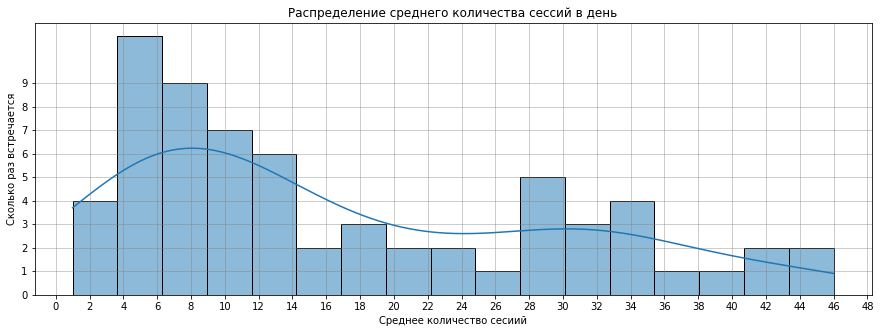

In [47]:
plt.figure(figsize=(15, 5))
sns.histplot(data=df_group_sess_days[df_group_sess_days['count_session'] < 50], x="count_session", kde=True, bins=17)
plt.title('Распределение среднего количества сессий в день')
plt.ylabel('Сколько раз встречается')
plt.xlabel('Среднее количество сесиий')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(0, 50, 2))
plt.yticks(np.arange(0, 10, 1))
plt.show()

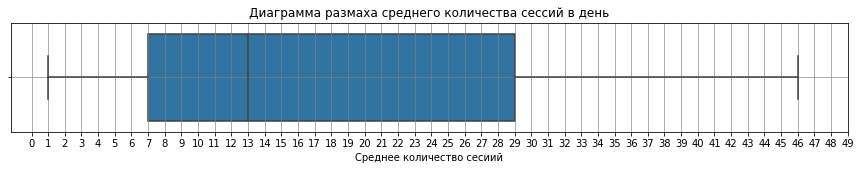

In [49]:
plt.rcParams['figure.figsize']=(15, 2)
sns.boxplot(x=df_group_sess_days['count_session'][df_group_sess_days['count_session'] < 50])
plt.title('Диаграмма размаха среднего количества сессий в день')
plt.xlabel('Среднее количество сесиий')
plt.grid(color='grey', axis='both', alpha=.8)
plt.xticks(np.arange(0, 50, 1))
plt.show()

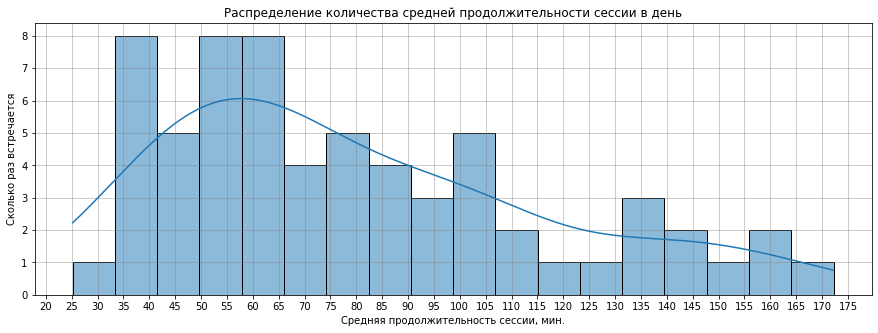

In [51]:
plt.figure(figsize=(15, 5))
sns.histplot(data=df_group_sess_days[df_group_sess_days['mean_time'] < 200], x="mean_time", kde=True, bins=18)
plt.title('Распределение количества средней продолжительности сессии в день')
plt.ylabel('Сколько раз встречается')
plt.xlabel('Средняя продолжительность сессии, мин.')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(20, 180, 5))
plt.show()

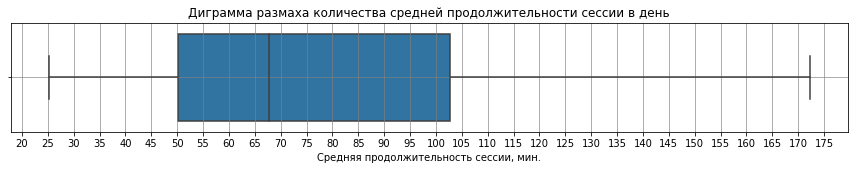

In [53]:
plt.rcParams['figure.figsize']=(15, 2)
sns.boxplot(x=df_group_sess_days['mean_time'][df_group_sess_days['mean_time'] < 200])
plt.title('Диграмма размаха количества средней продолжительности сессии в день')
plt.xlabel('Средняя продолжительность сессии, мин.')
plt.grid(color='grey', axis='both', alpha=.8)
plt.xticks(np.arange(20, 180, 5))

plt.show()

### Вывод

In [55]:
df_group_sess_days.describe()

,month,count_session,total_time,median_time,mean_time
count,67.000000,67.000000,67.000000,67.000000,67.000000
mean,9.895522,18.671642,1266.426418,51.588507,92.338806
std,3.158127,15.729135,821.560912,74.939892,67.481964
min,1.000000,1.000000,133.720000,6.620000,25.190000
25%,10.000000,7.000000,636.640000,14.295000,51.825000
50%,11.000000,13.000000,1197.080000,26.500000,72.360000
75%,12.000000,29.000000,1687.900000,56.335000,105.750000
max,12.000000,81.000000,4972.950000,401.800000,367.480000


При использовании ЛОЦМАН:КБ характерно следующее поведение пользователей:  
- среднее количество сессиий в день находятся в промежутке `от 7 до 29`;  
- средняя продолжительность сессиий находится в промежетку `от 51 до 106 минут`.

## Шаг 3. Определим количество требуемых лицензий

Выведем на экран, среднее среднего числа сессий, среднее серднего времени использования лицензий:

In [56]:
df_group_sess_days['count_session'].mean()

18.671641791044777

In [57]:
df_group_sess_days['mean_time'].mean()

92.33880597014925

Исходные данные:  
За 480 минут (8 часовой рабочий день) в среднем `18.67` сессий с ипользованием лицензий.  Среднее время использования лицензии `92.34` минут.  
Найдем оптимальное число лицензий для использования ПО ЛОЦМАН:

In [58]:
day_duration = 8 # продолжительность рабочего дня
clients = 18.67 # среднее число сессий
lambda_m = clients / day_duration # час^-1 интенсивность потока
t = 92.34/60 # среднее время использовании одной лицензии, час
nu = 1 / t # интенсивность использования лицензии, час^-1

ro = lambda_m / nu # интенсивность нагрузки

По формуле Эрланга определим вероятность того, что пользователь лицензию получил, при этом найдем значения вероятности при количестве лицензий от 1 до 10:

In [59]:
n = 10 # максимальное число лицензий
n_column = []

for j in range(1, n+1):
  po = 1
  count = 0

  for i in range(1, j+1):
    count= ro ** i / factorial(i)
    po += count

  po = po ** -1  
  p_otkaza = (ro ** j) * po / factorial(j)
  p_obsl = 1 - p_otkaza
  n_column.append([j, p_obsl])

columns = ['number_of_lic', 'p_give']
df_number_lic = pd.DataFrame(n_column, columns=columns) 

df_number_lic

,number_of_lic,p_give
0,1,0.217787
1,2,0.415850
2,3,0.588459
3,4,0.730179
4,5,0.837647
5,6,0.911423
6,7,0.956528
7,8,0.980856
8,9,0.992418
9,10,0.997284


Оптимальное количество лицензий можно считать `n = 7`, когда пользователь с вероятностью `95.7 %` получит лицензию. 

## Шаг 4. Вывод

1. Исходя из анализа *.log файлов сессий пользователей при использовании ЛОЦМАН:КБ начиная с 01.10.2021 г. по 19.01.2022 г. были определены статистические показатели портера пользователя.  

2. При использовании ЛОЦМАН:КБ характерно следующее поведение пользователей:  
  - среднее количество сессиий в день находятся в промежутке `от 7 до 29`;  
  - средняя продолжительность сессиий находится в промежетку `от 51 до 106 минут`.

3. Определено, что для использования программного обеспечения ЛОЦМАН:КБ, оптимальное количество лицензий:  `7 штук`, такое количество лицензий позволит с вероятностью `95.7 %` получить пользователю доступ к программе.